In [225]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import dicom
import os
from tqdm import tqdm

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

In [226]:
INPUT_FOLDER = 'data/small_data/'
NPY_FOLDER = 'data/small_data_npy/'
LUNG_MASK_FOLDER = 'data/small_data_masks/'
IMAGE_ROI_FOLDER = 'data/small_data_ROI/'

patients = os.listdir(INPUT_FOLDER)
patients_NPY = glob(NPY_FOLDER + "/*.npy")
patients_lung_masks = glob(LUNG_MASK_FOLDER + "/*.npy")

patients.sort()
patients_NPY.sort()
patients_lung_masks.sort()

In [227]:
patients[0]

'0a099f2549429d29b32f349e95fb2244'

In [228]:
for patient in patients[:2]:
    patient_images = glob(INPUT_FOLDER + patient + "/*.dcm")
    slices = np.array([dicom.read_file(path).pixel_array for path in patient_images])
    np.save(os.path.join(NPY_FOLDER, "%s.npy" % (patient)),slices)

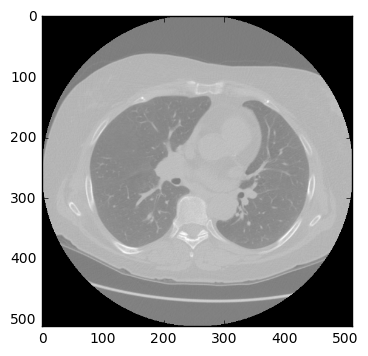

In [229]:
img1 = np.load(NPY_FOLDER+'0a099f2549429d29b32f349e95fb2244.npy').astype(np.float64)
plt.imshow(img1[21], cmap=plt.cm.gray)
plt.show()

In [230]:
for array in patients_NPY:
    imgs_to_process = np.load(array).astype(np.float64)
    img_file = array.rsplit('/',1)[1]
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img < threshold, 1.0, 0.0)  # threshold the image
        #
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        #
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        #
        #  Label each region and obtain the region properties
        #  The background region is removed by removing regions 
        #  with a bbox that is to large in either dimnsion
        #  Also, the lungs are generally far away from the top 
        #  and bottom of the image, so any regions that are too
        #  close to the top and bottom are removed
        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity. 
        #
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        imgs_to_process[i] = mask
    np.save(LUNG_MASK_FOLDER + img_file,imgs_to_process)

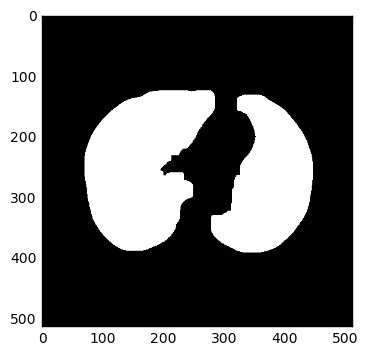

In [231]:
img2 = np.load(LUNG_MASK_FOLDER+'0a099f2549429d29b32f349e95fb2244.npy').astype(np.float64)
plt.imshow(img2[21], cmap=plt.cm.gray)
plt.show()

In [232]:
for fname in patients_lung_masks:
    out_images = []
    img_file = fname.rsplit('/',1)[1]
    print("working on file ", img_file)
    imgs_to_process = np.load(fname.replace("small_data_masks","small_data_npy"))
    masks = np.load(fname)
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            out_images.append(new_img)
    np.save(IMAGE_ROI_FOLDER + img_file,out_images)

working on file  0a099f2549429d29b32f349e95fb2244.npy
working on file  0a0c32c9e08cc2ea76a71649de56be6d.npy


/home/dima/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dima/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dima/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dima/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


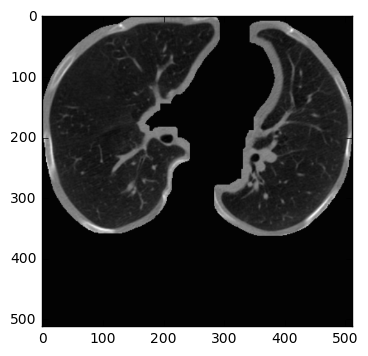

In [233]:
img3 = np.load(IMAGE_ROI_FOLDER+'0a099f2549429d29b32f349e95fb2244.npy').astype(np.float64)
plt.imshow(img3[21], cmap=plt.cm.gray)
plt.show()